# Introduction

### Overview:
With the arrival of [new medical documentation in the US](https://www.healthcareitnews.com/news/how-sdoh-will-influence-next-wave-health-tech-startups) it is possible to build a model that can classify symptom names based upon input text from patients describing their illness.

Utilized Keras to generate a Convolutional Neural Network (CNN) and dense neural network with a 200 dimensional Genism Word2Vec embedding and 6,650 records of patient condition descriptions to predict symptoms with a close to 100% test accuracy from both models.

### SetUp:
1. Install all packages from the Import statement.
2. The 200 dimensional Word2Vec file of glove.6B.200d.txt can be downloaded at a zip file [here](http://nlp.stanford.edu/data/glove.6B.zip) (822 MB). See main page at the [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/) introduction page.
3. Designate the file path of the input data and Gensim embedding file as a string in the 'directory' object.
4. Download data file from github [here](https://github.com/amoskowitz14/disease_prompt_nlp_model/blob/master/phrase_disease_data.csv)

### Sources:
1. [Word Embedding use in Keras](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

2. [Original Data Source from Figure Eight](https://www.figure-eight.com/dataset/audio-recording-and-transcription-for-medical-scenarios/)

3. [Convolutional Neural Networks in Keras](https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn)

### Author:
[Aaron Moskowitz](https://www.linkedin.com/in/aaroncmoskowitz/)

# Import

In [1]:
# Directory Configuration
import os

# Goolge Colab Setup
from google.colab import drive

# Object Manipulation
import numpy as np
import pandas as pd

# Word2Vec Import
import gensim
from gensim.test.utils import datapath

# Tokenizer
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

# Embedding Creation
from numpy import asarray
from numpy import zeros

# Keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Activation, Dense, Embedding, Flatten

# Test Train Split
from sklearn.model_selection import train_test_split

# Visulization
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


# Setup of project directory, or use of google Colab to run code

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
directory = "/content/drive/My Drive/Colab Notebooks/Deep_Learning_NLP/Keras_Healthcare_NLP_Project"

In [0]:
os.chdir(directory)

In [0]:
glove_file = datapath(directory + '/glove/glove.6B.200d.txt')

# Load Embedding

### Load the whole 200 dimensional embedding into memory

In [0]:
embeddings_index = dict()

f = open(datapath(glove_file))
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

### Confirm Gensin embedding is expected

In [7]:
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [8]:
print('''Confirm the embedding of a relevant word such as 'head' with its embedding size of''', len(embeddings_index['head']), 'is expected.')
print('View first 5 ellements of the embedding to see if it is plausible. First ellements are', embeddings_index['head'][0:5])

Confirm the embedding of a relevant word such as 'head' with its embedding size of 200 is expected.
View first 5 ellements of the embedding to see if it is plausible. First ellements are [-0.26623  -0.75065  -0.031357 -0.03684  -0.1875  ]


# Import Data

In [9]:
# Load data from csv
input_data = pd.read_csv(directory + '/data/phrase_disease_data.csv') 

# 5th and 6thh column have phrase and prompt respectively
col = ['phrase', 'prompt']
input_data = input_data[col]

# Get phrases into a series
phrases = input_data['phrase']
prompts = input_data['prompt']

print('Data import has rows of:', len(input_data))

Data import has rows of: 6650


### View 5 example phrases and associated prompts in data to confirm upload worked as expected

In [10]:
phrases.head()

0                      When I remember her I feel down
1    When I carry heavy things I feel like breaking...
2            there is too much pain when i move my arm
3    My son had his lip pierced and it is swollen a...
4               My muscles in my lower back are aching
Name: phrase, dtype: object

In [11]:
prompts.head()

0      Emotional pain
1    Hair falling out
2         Heart hurts
3      Infected wound
4      Infected wound
Name: prompt, dtype: object

# Create One Hot Encoding and Dictionary for Prompts

## Create integer dictionary for pompts

In [0]:
# Get prompt and replace space with underscore
prompt = [word.replace(" ","_").lower() for word in prompts]

# Adding a column of category_id encoding the prompt as an integer to ease in represenation of class
input_data['category_id'] = prompts.factorize()[0]
category_id_df = input_data[['prompt', 'category_id']].drop_duplicates().sort_values('category_id')

# Generate dictionary to code categorical_id back to prompt
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'prompt']].values)

# Converting promopts to a list of integers
prompt = list(input_data['category_id'])

### View prompt_id to prompt dictionary

In [13]:
print('The size of the dictionary is', len(set(prompt)))

print('\nView entire dictionary:')
id_to_category

The size of the dictionary is 25

View entire dictionary:


{0: 'Emotional pain',
 1: 'Hair falling out',
 2: 'Heart hurts',
 3: 'Infected wound',
 4: 'Foot ache',
 5: 'Shoulder pain',
 6: 'Injury from sports',
 7: 'Skin issue',
 8: 'Stomach ache',
 9: 'Knee pain',
 10: 'Joint pain',
 11: 'Hard to breath',
 12: 'Head ache',
 13: 'Body feels weak',
 14: 'Feeling dizzy',
 15: 'Back pain',
 16: 'Open wound',
 17: 'Internal pain',
 18: 'Blurry vision',
 19: 'Acne',
 20: 'Muscle pain',
 21: 'Neck pain',
 22: 'Cough',
 23: 'Ear ache',
 24: 'Feeling cold'}

## Create one hot encoding representation of prompt

In [14]:
prompt[0:5]

[0, 1, 2, 3, 3]

In [15]:
prompt_length = len(np.array(prompt))
class_len = len(set(prompt))
print('Confirm prompt length is unchanged:', class_len)

Confirm prompt length is unchanged: 25


In [0]:
prompt_length = len(np.array(prompt))

empty_array = np.zeros((prompt_length, class_len))
empty_array[np.arange(prompt_length), prompt] = 1
prompt_one_hot = empty_array

In [17]:
prompt_one_hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
print('Confirm that all records are covered in one hot encoding:', len(prompt_one_hot))

Confirm that all records are covered in one hot encoding: 6650


# Prepare data features

In [59]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(phrases.tolist())
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_docs = t.texts_to_sequences(phrases.tolist())
print(encoded_docs[0:5])

[[10, 1, 583, 125, 1, 7, 77], [10, 1, 261, 99, 185, 1, 7, 18, 416, 2, 23], [35, 11, 91, 94, 6, 10, 1, 106, 2, 98], [2, 189, 52, 167, 301, 439, 8, 13, 11, 179, 8, 9, 40, 89, 15, 167, 301, 11, 584, 8, 190, 83], [2, 145, 4, 2, 136, 23, 73, 224]]


In [20]:
print('The training data phrase word count is the covabulary size of', vocab_size)

The training data phrase word count is the covabulary size of 1160


In [21]:
# pad documents to a max length of the longest word
max_length = 0
for doc in encoded_docs:
  if len(doc) > max_length:
    max_length = len(doc)

print('The training data with the longest word length is', max_length)

padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

The training data with the longest word length is 30


In [22]:
print('Confirm that the padded_docs has the correct size of', len(padded_docs))

Confirm that the padded_docs has the correct size of 6650


In [23]:
print('Confirm that the phrase below has the same number of non zero tokens in the padded document', phrases[1])

Confirm that the phrase below has the same number of non zero tokens in the padded document When I carry heavy things I feel like breaking my back


In [24]:
print('See padded document for the position 1 phrase', padded_docs[1])

See padded document for the position 1 phrase [ 10   1 261  99 185   1   7  18 416   2  23   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


### Add an index in front of each padded phrase to allow tracking of the true prompt

In [25]:
indexed_padded_docs = list()

counter = 0
for row in padded_docs:
  indexed_padded_docs.append(list((counter, row)))
  counter = counter + 1

indexed_padded_docs = np.array(indexed_padded_docs)

print(type(indexed_padded_docs))
print(len(indexed_padded_docs))
print(indexed_padded_docs[0:4])

<class 'numpy.ndarray'>
6650
[[0
  array([ 10,   1, 583, 125,   1,   7,  77,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)]
 [1
  array([ 10,   1, 261,  99, 185,   1,   7,  18, 416,   2,  23,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)]
 [2
  array([ 35,  11,  91,  94,   6,  10,   1, 106,   2,  98,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)]
 [3
  array([  2, 189,  52, 167, 301, 439,   8,  13,  11, 179,   8,   9,  40,
        89,  15, 167, 301,  11, 584,   8, 190,  83,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)]]


In [26]:
len(padded_docs)

6650

# Prepare Weights for Data from Embedding

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 200))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [28]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.26804999,  0.36032   , -0.33199999, ...,  0.17769   ,
         0.22362   ,  0.014241  ],
       [ 0.30379999,  0.18126   ,  0.46583   , ...,  0.29550999,
        -0.25325999,  0.72632998],
       ...,
       [ 0.077027  , -0.25341001, -0.15026   , ...,  0.2938    ,
        -0.23005   , -0.17716999],
       [ 0.29876   , -0.14601   , -0.15304001, ...,  0.28331   ,
        -0.11579   ,  0.92505997],
       [ 0.55844998,  0.66096002,  0.32642999, ...,  0.17189001,
         0.050269  , -0.42519999]])

In [29]:
type(embedding_matrix)

numpy.ndarray

In [30]:
np.shape(embedding_matrix)

(1160, 200)

In [31]:
vocab_size

1160

# Test Train Split

In [0]:
#split the data into training and validation set with 80%, 20% respectively
train_x, test_x, train_y, test_y = train_test_split(indexed_padded_docs ,prompt_one_hot, test_size=0.2, random_state=1,shuffle=True)

### Confirm that sizes of features and target in both the train and test are the same, and view sample of train set.

In [33]:
print(len(train_x))
print(len(train_y))
print(len(test_x))
print(len(test_y))

5320
5320
1330
1330


In [34]:
train_x[0:5]

array([[102,
        array([  1,   5,  36,  48,  41,  22, 257,  79, 188,   1, 110,   5,   3,
        33,  53, 218,  53, 139, 342, 445, 113,  36, 963,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)],
       [589,
        array([ 35,  11,   3,  50,   6,   4,   2, 744,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)],
       [5323,
        array([ 1, 75,  2, 55, 11, 83,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)],
       [1558,
        array([ 10,   1,  26, 966,   2,  28,  13,  26,  95,  30, 967,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)],
       [1228,
        array([ 25, 309,   1,   5, 173,  93,  89,  14,  24,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int

### Create helper function to convert indexed array to non-indexed array for use in training

In [35]:
def to_non_indexed_array(indexed_array):
   
  non_indexed_list = list()

  counter = 0
  for row in indexed_array:

    non_indexed_list.append(row[1])
    counter = counter + 1

  non_indexed_array = np.array(non_indexed_list)
  
  return(non_indexed_array)

to_non_indexed_array(test_x)

array([[  1,  86, 260, ...,   0,   0,   0],
       [ 25, 111, 112, ...,   0,   0,   0],
       [  2, 759,  37, ..., 585,  21, 761],
       ...,
       [  1,   5, 105, ...,   0,   0,   0],
       [  2, 845,   8, ...,   0,   0,   0],
       [  2,  38,  37, ...,   0,   0,   0]], dtype=int32)

# Create Dense Neural Network

In [36]:
# Define model
model_dense = Sequential()

# Embedding Layers
e = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=max_length, trainable=False)
model_dense.add(e)
model_dense.add(Flatten())

# Dense layer
model_dense.add(Dense(len(set(prompt))))

# Output Layer
model_dense.add(Activation('softmax'))

# Compile Model
model_dense.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize Model
print(model_dense.summary())

# Fit Model
model_dense.fit(to_non_indexed_array(train_x), train_y, epochs=3, verbose=0)

# Evaluate Model
loss, accuracy = model_dense.evaluate(to_non_indexed_array(test_x), test_y, verbose=0)
print('Accuracy: %f' % (accuracy*100))







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 200)           232000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                150025    
_________________________________________________________________
activation_1 (Activation)    (None, 25)                0         
Total params: 382,025
Trainable params: 150,025
Non-trainable params: 232,000
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Accuracy: 99.248120


# Create Convolutional Neural Network

In [53]:
cnn_model = Sequential()

# Embedding Layer
e = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=max_length, trainable=False)
cnn_model.add(e)

# Convolutional and Max Pooling Layer
cnn_model.add(layers.Conv1D(128, 5, activation='relu'))
cnn_model.add(layers.GlobalMaxPooling1D())

# Dense Layer
cnn_model.add(layers.Dense(10, activation='relu'))

# Output Layer
cnn_model.add(layers.Dense(len(set(prompt)), activation='sigmoid'))
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summarize Model
cnn_model.summary()

# Fit Model
history = cnn_model.fit(to_non_indexed_array(train_x),train_y,
                    epochs=3,
                    verbose=1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 30, 200)           232000    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 26, 128)           128128    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_15 (Dense)             (None, 25)                275       
Total params: 361,693
Trainable params: 129,693
Non-trainable params: 232,000
_________________________________________________________________
Epoch 1/3
5320/5320 [==============================] - 2s 331us/step - loss: 0.1990 - acc: 0.9391
Epoch 2/3


# Evaluate Model

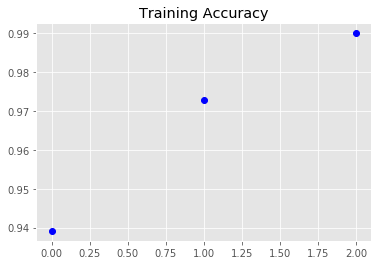

In [54]:
#History Object Preserves Training Accuracy
loss = history.history['acc']

#Number of Epochs
epochs = range(len(loss))

plt.figure()

# Plot Training Accuracy
plt.plot(epochs, loss, 'bo', label='Training Accuracy')
plt.title('Training Accuracy')
plt.show()

In [55]:
# evaluate the model
loss, accuracy = cnn_model.evaluate(to_non_indexed_array(test_x), test_y, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 99.371429


# Exploration of Output

In [0]:
def exploration_output(model_exploration, num, verbose = True):
  '''Parameters: model_exploration - type: keras.engine.sequential.Sequential
    num - type: integer - Element in the test set to view the actual class and scores of predicted classes
    verbose - type: boolean - If True, prints details out phrase of the num element in the test set, and the true class of the element.
    Output: Descending dataframe of most probable classes ordered by softmax scoring
  '''
  if verbose:
    print('Testing output from phrase of:', phrases[test_x[num][0]])

  model_exploration.predict(to_non_indexed_array(test_x), verbose=0)[num]

  results = pd.DataFrame(columns=['Class Id', 'Prompt', 'Score'])
  results = list()
  index = 0
  for score in model_exploration.predict(to_non_indexed_array(test_x), verbose=0)[num]:
    row = list((index, id_to_category.get(index), score))
    results.append(row)
    index = index + 1

  results = pd.DataFrame(columns=['Class Id', 'Prompt', 'Score'], data = results)
  
  if verbose:
    print('True class is:', id_to_category.get(np.argmax(test_y[num])))
    
  return(results.sort_values(by='Score', ascending = False).head())

In [57]:
exploration_output(model_dense, 5)

Testing output from phrase of: I feel a pain on the left side of my chest, where my heart is
True class is: Heart hurts


,Class Id,Prompt,Score
2,2,Heart hurts,0.913194
4,4,Foot ache,0.025469
5,5,Shoulder pain,0.012864
12,12,Head ache,0.009703
10,10,Joint pain,0.008669


In [58]:
exploration_output(cnn_model, 5)

Testing output from phrase of: I feel a pain on the left side of my chest, where my heart is
True class is: Heart hurts


,Class Id,Prompt,Score
2,2,Heart hurts,0.810164
3,3,Infected wound,0.039408
15,15,Back pain,0.033659
9,9,Knee pain,0.030153
12,12,Head ache,0.015866
